# Step 1 – Import Libraries & Load Data

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# Step 1: Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
# Handle class imbalance
from imblearn.over_sampling import SMOTE

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load dataset
df = pd.read_csv("filtered_loans.csv")

# Step 3: Quick check of dataset
print(df.shape)
df.head()

(39202, 41)


,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,10.65,162.87,10,24000.0,1,860,27.65,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,15.27,59.83,0,30000.0,0,309,1.00,0.0,744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2400.0,15.96,84.33,10,12252.0,1,606,8.72,0.0,739.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000.0,13.49,339.31,10,49200.0,1,917,20.00,0.0,694.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5000.0,7.90,156.46,3,36000.0,1,852,11.20,0.0,734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


# Step 2 – Data Description, EDA, and Data Preprocessing.

In [7]:
# Basic info
df.info()

# Summary statistics
df.describe()

# Check missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            39202 non-null  float64
 1   int_rate                             39202 non-null  float64
 2   installment                          39202 non-null  float64
 3   emp_length                           39202 non-null  int64  
 4   annual_inc                           39202 non-null  float64
 5   loan_status                          39202 non-null  int64  
 6   zip_code                             39202 non-null  int64  
 7   dti                                  39202 non-null  float64
 8   delinq_2yrs                          39202 non-null  float64
 9   fico_range_high                      39202 non-null  float64
 10  inq_last_6mths                       39202 non-null  float64
 11  open_acc                    

loan_amnt                              0
int_rate                               0
installment                            0
emp_length                             0
annual_inc                             0
loan_status                            0
zip_code                               0
dti                                    0
delinq_2yrs                            0
fico_range_high                        0
inq_last_6mths                         0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc                              0
last_fico_range_high                   0
home_ownership_MORTGAGE                0
home_ownership_NONE                    0
home_ownership_OTHER                   0
home_ownership_OWN                     0
home_ownership_RENT                    0
verification_status_Not Verified       0
verification_status_Source Verified    0
verification_sta

In [8]:

# 4. CHECK FOR MISSING VALUES

missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing_counts,
    "Missing %": missing_percent
}).sort_values(by="Missing %", ascending=False)

print("Missing Values Overview:\n", missing_df)

# Handling missing values 
# Numeric: fill with median
# Categorical: fill with most frequent value (mode)
for col in df.columns:
    if df[col].dtype in ["float64", "int64"]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)


Missing Values Overview:
                                      Missing Count  Missing %
loan_amnt                                        0        0.0
home_ownership_RENT                              0        0.0
verification_status_Source Verified              0        0.0
verification_status_Verified                     0        0.0
purpose_car                                      0        0.0
purpose_credit_card                              0        0.0
purpose_debt_consolidation                       0        0.0
purpose_educational                              0        0.0
purpose_home_improvement                         0        0.0
purpose_house                                    0        0.0
purpose_major_purchase                           0        0.0
purpose_medical                                  0        0.0
purpose_moving                                   0        0.0
purpose_other                                    0        0.0
purpose_renewable_energy                    

In [9]:

# 5. CHECK FOR DUPLICATES

duplicates = df.duplicated().sum()
print(f"Duplicate Rows Found: {duplicates}")

# Remove duplicates if found
if duplicates > 0:
    df.drop_duplicates(inplace=True)


Duplicate Rows Found: 0


In [10]:

# 6. OUTLIER DETECTION AND HANDLING (IQR METHOD)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers found — capping values")
        # Cap extreme values instead of removing them
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


loan_amnt: 1155 outliers found — capping values
int_rate: 54 outliers found — capping values
installment: 1276 outliers found — capping values
annual_inc: 1876 outliers found — capping values
loan_status: 5650 outliers found — capping values
delinq_2yrs: 4262 outliers found — capping values
fico_range_high: 3 outliers found — capping values
inq_last_6mths: 3602 outliers found — capping values
open_acc: 508 outliers found — capping values
pub_rec: 2102 outliers found — capping values
revol_bal: 2452 outliers found — capping values
total_acc: 519 outliers found — capping values
last_fico_range_high: 32 outliers found — capping values
home_ownership_NONE: 3 outliers found — capping values
home_ownership_OTHER: 96 outliers found — capping values
home_ownership_OWN: 3023 outliers found — capping values
purpose_car: 1534 outliers found — capping values
purpose_credit_card: 5077 outliers found — capping values
purpose_educational: 322 outliers found — capping values
purpose_home_improvement: 

In [11]:
# Summary Statistics for Key Variables


import pandas as pd

# Load the filtered loans dataset
df = pd.read_csv("filtered_loans.csv")

# Select key numerical variables for summary statistics
numerical_vars = [
    "loan_amnt", "int_rate", "installment", "annual_inc",
    "dti", "fico_range_high", "last_fico_range_high"
]

# Compute summary statistics
summary_stats = df[numerical_vars].describe().T

# Rename columns for readability
summary_stats = summary_stats.rename(columns={
    "mean": "Mean",
    "std": "Std. Dev.",
    "min": "Min",
    "max": "Max"
})

# Keep only relevant columns and round values
summary_stats = summary_stats[["Mean", "Std. Dev.", "Min", "Max"]].round(2)

# Display the table
print(summary_stats)

# OPTIONAL: Save to CSV for report inclusion
summary_stats.to_csv("summary_statistics.csv")


                          Mean  Std. Dev.      Min         Max
loan_amnt             11145.39    7400.19   500.00    35000.00
int_rate                 11.98       3.71     5.42       24.59
installment             323.52     208.48    15.69     1305.19
annual_inc            68919.96   63990.17  4000.00  6000000.00
dti                      13.30       6.68     0.00       29.99
fico_range_high         719.02      35.87   629.00      829.00
last_fico_range_high    691.87      79.54     0.00      850.00


Class Counts:
 loan_status
1    33552
0     5650
Name: count, dtype: int64

Class Percentages:
 loan_status
1    85.58747
0    14.41253
Name: proportion, dtype: float64


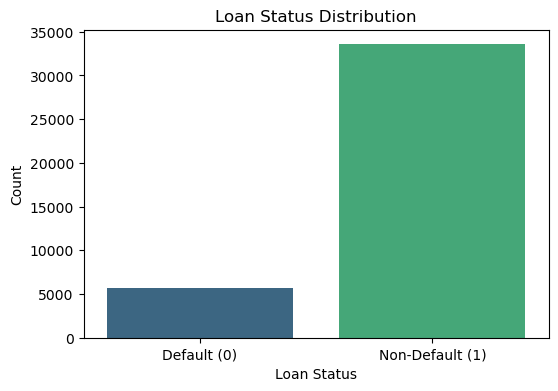

In [12]:

# 7. TARGET VARIABLE DISTRIBUTION (CLASS IMBALANCE CHECK)

class_counts = df['loan_status'].value_counts()
class_perc = df['loan_status'].value_counts(normalize=True) * 100

print("Class Counts:\n", class_counts)
print("\nClass Percentages:\n", class_perc)

# Plot the target distribution
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xticks([0, 1], ['Default (0)', 'Non-Default (1)'])
plt.ylabel('Count')
plt.xlabel('Loan Status')
plt.title('Loan Status Distribution')
plt.show()


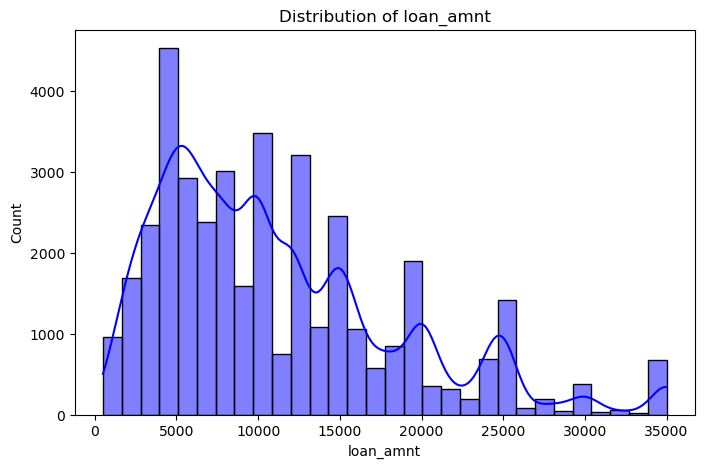

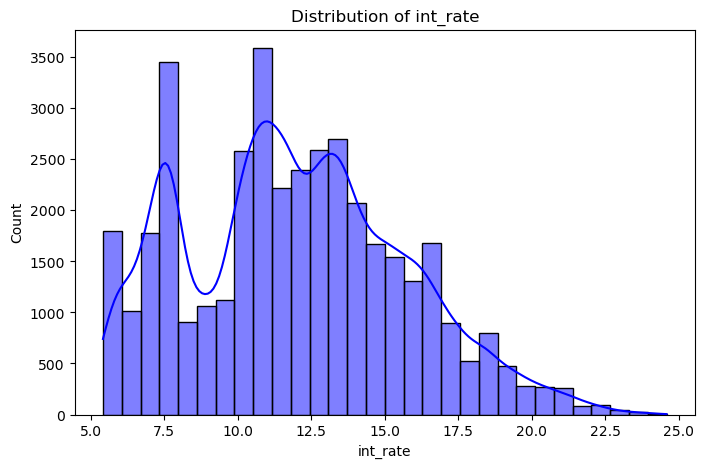

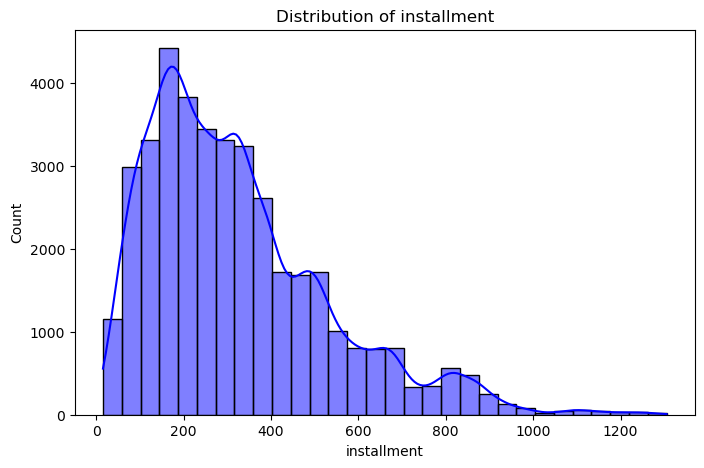

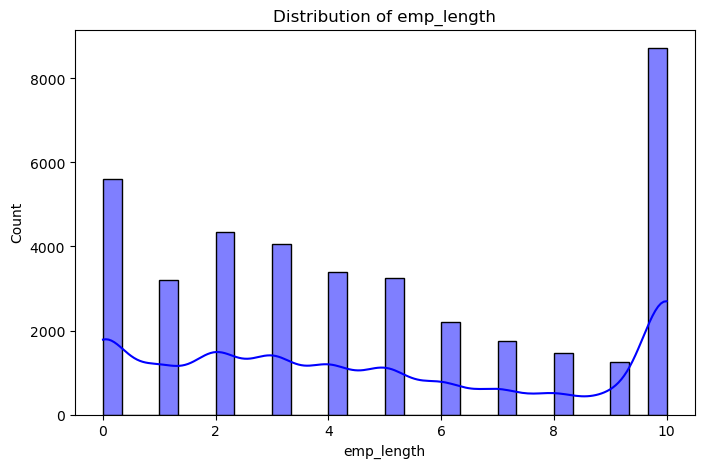

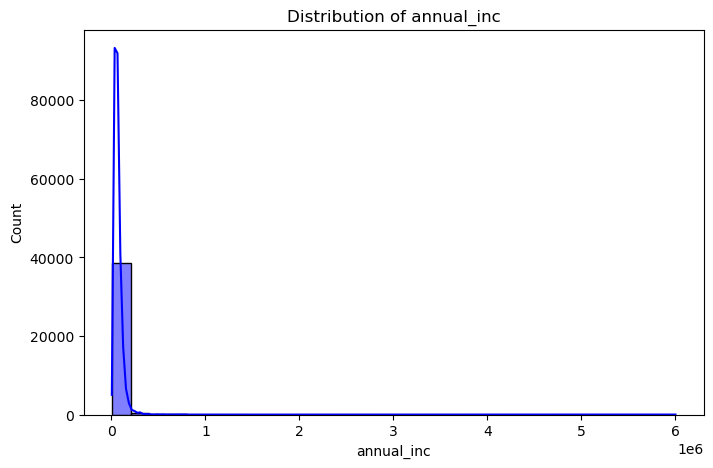

In [13]:

# 8. FEATURE DISTRIBUTIONS (NUMERIC)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("loan_status")  # Remove target

for col in numeric_cols[:5]:  # First 5 for quick view, expand if needed
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.show()


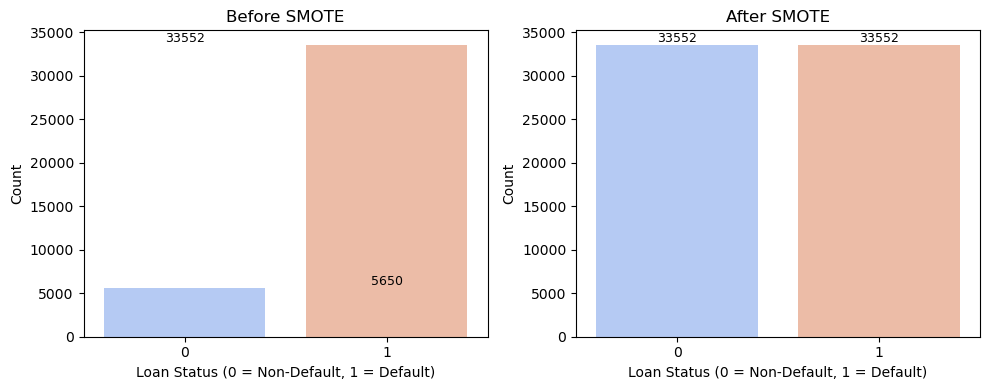

In [14]:

# Figure 8.1 - Class Distribution Before and After SMOTE


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE



# Separate features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Count distribution before SMOTE
before_counts = y.value_counts()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Count distribution after SMOTE
after_counts = y_bal.value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before SMOTE plot
sns.barplot(x=before_counts.index, y=before_counts.values, ax=axes[0], palette="coolwarm")
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Loan Status (0 = Non-Default, 1 = Default)")
axes[0].set_ylabel("Count")
for i, val in enumerate(before_counts.values):
    axes[0].text(i, val, str(val), ha="center", va="bottom", fontsize=9)

# After SMOTE plot
sns.barplot(x=after_counts.index, y=after_counts.values, ax=axes[1], palette="coolwarm")
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Loan Status (0 = Non-Default, 1 = Default)")
axes[1].set_ylabel("Count")
for i, val in enumerate(after_counts.values):
    axes[1].text(i, val, str(val), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


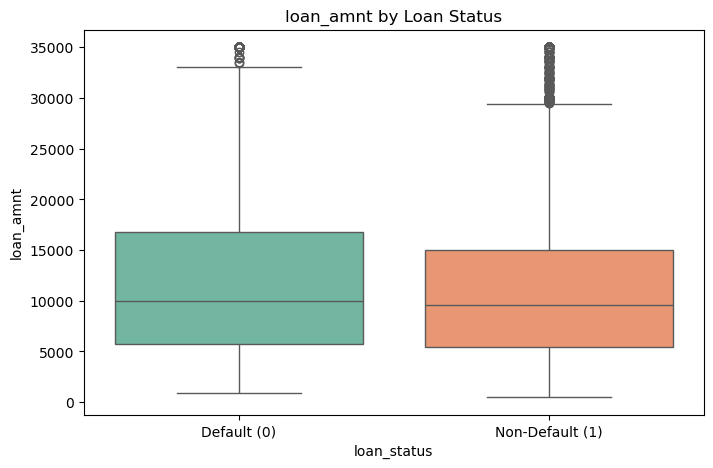

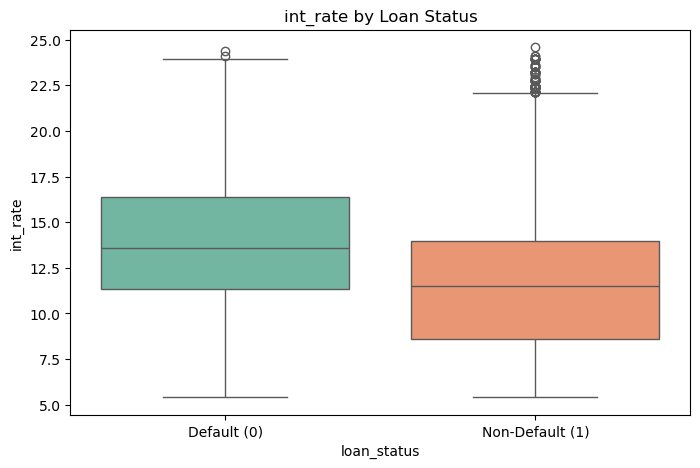

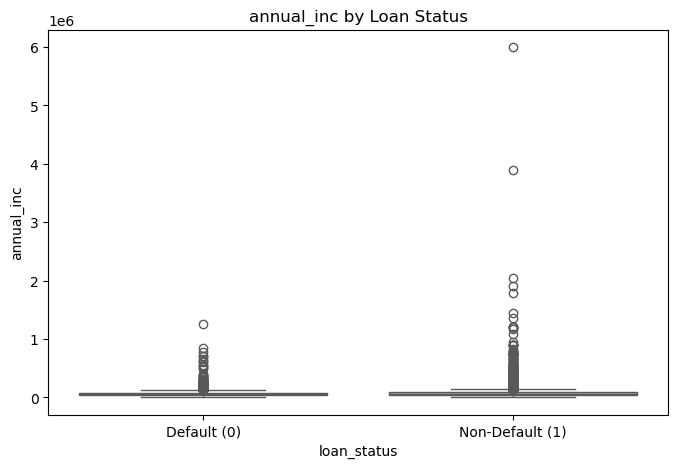

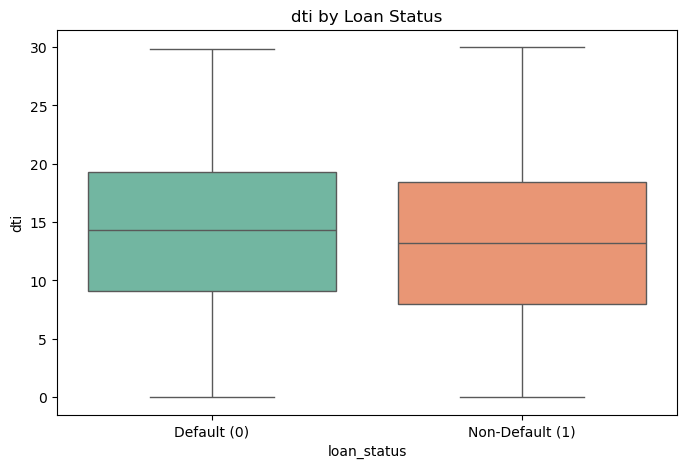

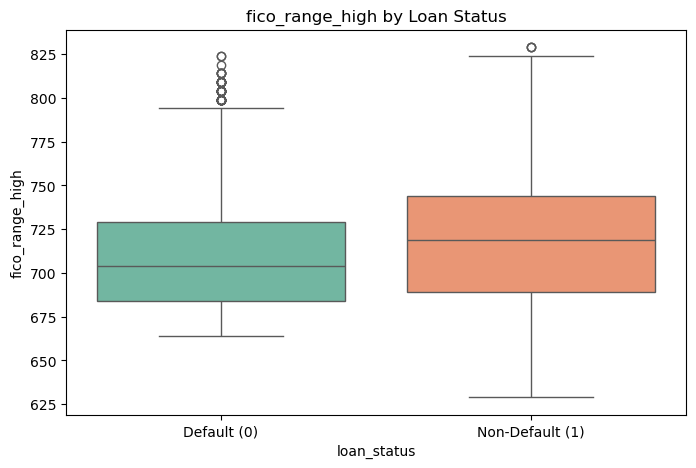

In [15]:

# 9. RELATIONSHIP BETWEEN FEATURES & TARGET

features_to_plot = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_high']

for col in features_to_plot:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='loan_status', y=col, data=df, palette="Set2")
    plt.xticks([0, 1], ['Default (0)', 'Non-Default (1)'])
    plt.title(f"{col} by Loan Status")
    plt.show()


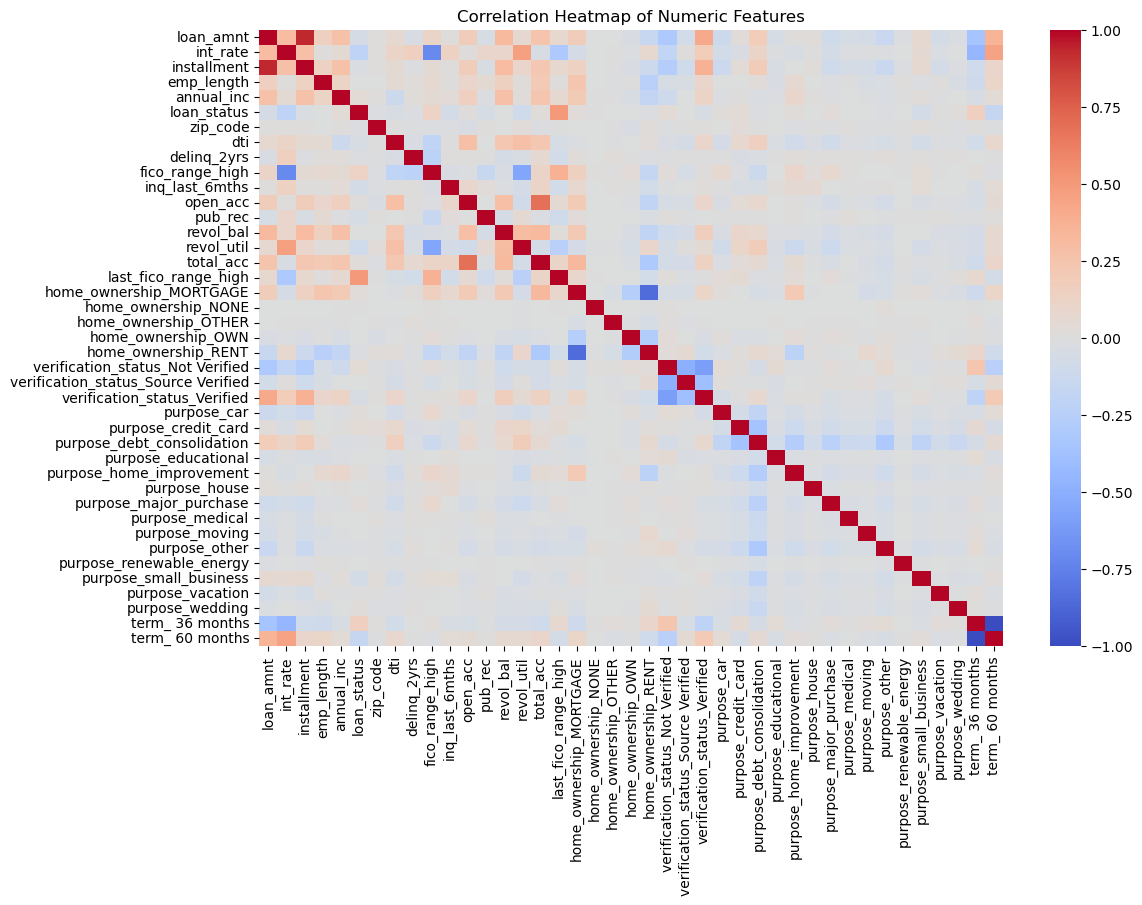

In [16]:

# 10. CORRELATION HEATMAP

corr_matrix = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [17]:

# 11. FEATURE SCALING

# Standardize numerical variables (mean=0, std=1) for modelling
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("loan_status")  # Exclude target

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [18]:
pip install --upgrade threadpoolctl imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import pandas as pd
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("filtered_loans.csv")

# Separate features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

print("Before SMOTE:\n", y.value_counts())

# Run SMOTE (no n_jobs in v0.13)
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

print("\nAfter SMOTE:\n", pd.Series(y_bal).value_counts())


Before SMOTE:
 loan_status
1    33552
0     5650
Name: count, dtype: int64

After SMOTE:
 loan_status
1    33552
0    33552
Name: count, dtype: int64


In [20]:
df = pd.read_csv("filtered_loans.csv")
print(df['loan_status'].value_counts())


loan_status
1    33552
0     5650
Name: count, dtype: int64


# Step 3 – Train/Test Split & Feature Scaling

In [22]:
# Step 3: Train/Test Split

# Now that SMOTE has balanced my dataset (equal number of 0 and 1 classes),
# I need to split it into two parts:
#   - Training Set: 70% of the data → used to train my models.
#   - Testing Set: 30% of the data → used to test my models on unseen data.
#
# I am using 'stratify=y_bal' to make sure both sets keep the same class balance.
# Setting 'random_state=42' so that my results are reproducible every time I run the code.

X_train, X_test, y_train, y_test = train_test_split(
    X_bal,               # Balanced feature set from SMOTE
    y_bal,               # Balanced target from SMOTE
    test_size=0.3,       # 30% for testing, 70% for training
    random_state=42,     # Ensures the same split every time
    stratify=y_bal       # Keeps the class distribution equal in both sets
)

# Let's check the sizes of the training and testing sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

# Let's also confirm the class balance in each set
print("\nClass distribution in training set:\n", y_train.value_counts())
print("\nClass distribution in testing set:\n", y_test.value_counts())


Training set size: (46972, 40)
Testing set size: (20132, 40)

Class distribution in training set:
 loan_status
0    23486
1    23486
Name: count, dtype: int64

Class distribution in testing set:
 loan_status
1    10066
0    10066
Name: count, dtype: int64


Why this step is important
Prevents overfitting → by keeping a separate test set, I can evaluate my models on data they haven’t seen before.

Maintains class balance → stratified splitting ensures both sets have equal representation of 0 and 1.

Reproducibility → using random_state=42 means I can get the same split in future runs for consistency.

# Step 4 — Training My Machine Learning Models

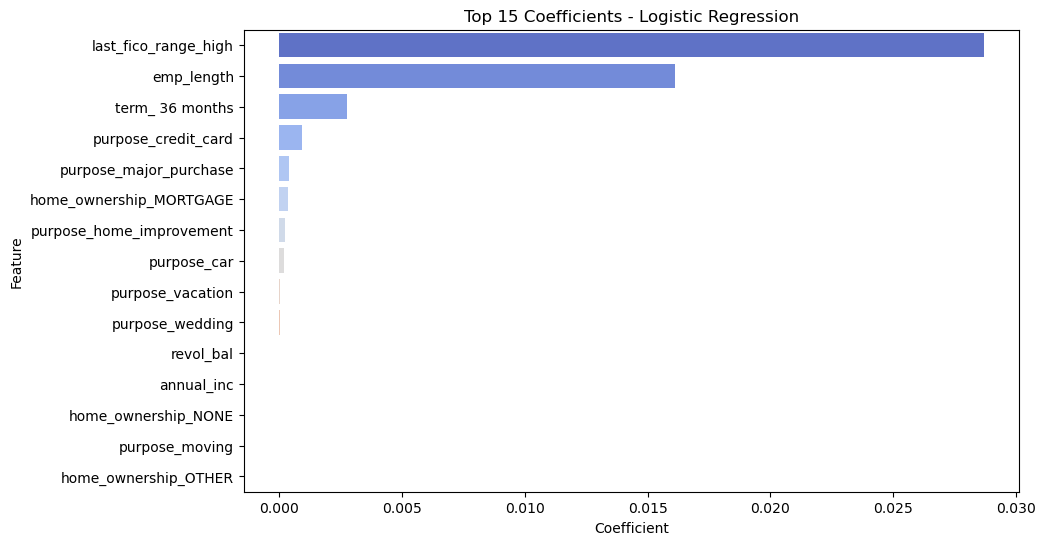

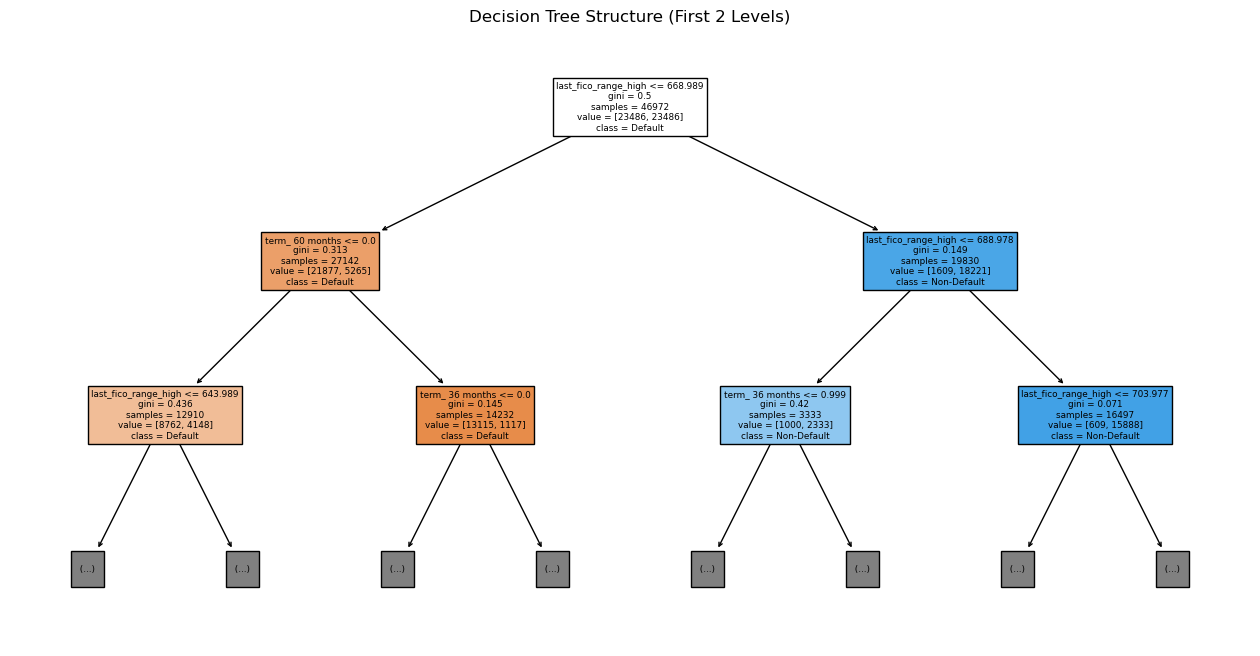

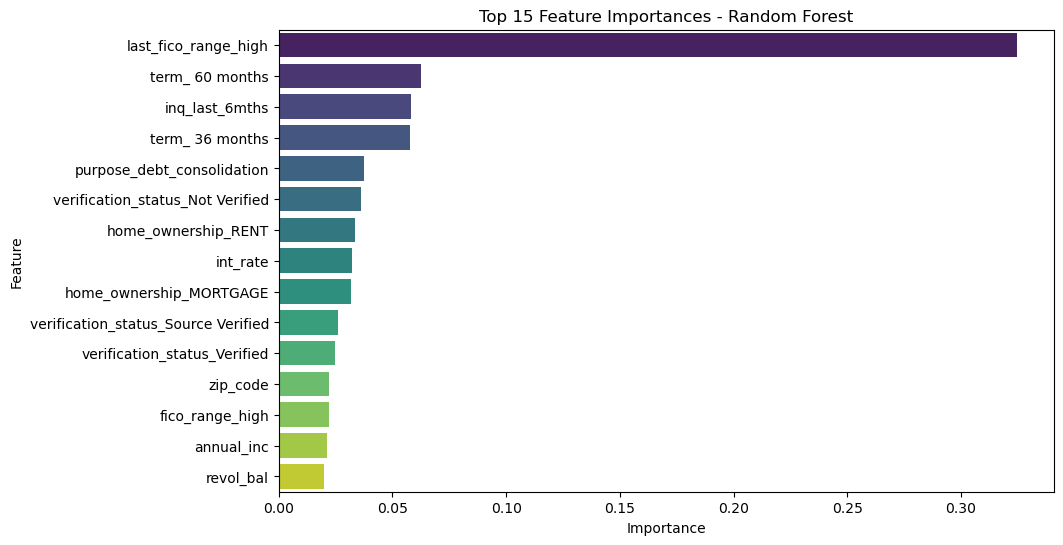

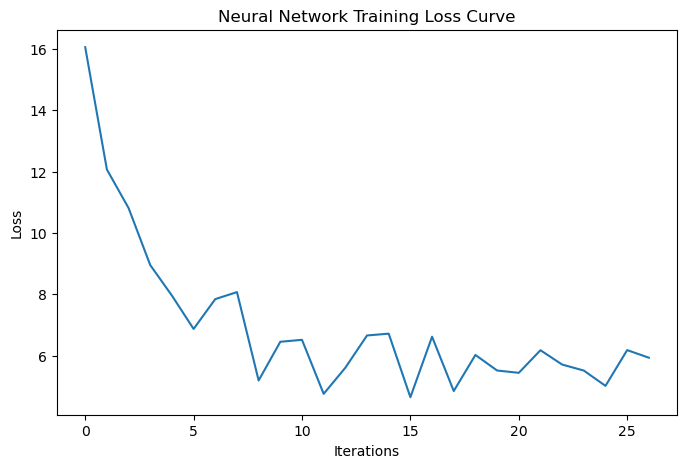

All models have been trained successfully.


In [25]:

# Step 4: Training My Machine Learning Models

# Now that my dataset is split into training and testing sets,
# I can train a few different machine learning models to see which one performs best.
#
# I will try 4 different algorithms:
#  1. Logistic Regression  - A good baseline for binary classification.
#  2. Decision Tree         - Learns rules from data and is easy to interpret.
#  3. Random Forest         - A group (ensemble) of decision trees for better accuracy.
#  4. Neural Network (MLP)  - Can model complex, non-linear relationships.
#
# I will train each of them on the training data (X_train, y_train).

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Visualising coefficient importance
import numpy as np
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df.head(15), palette="coolwarm")
plt.title("Top 15 Coefficients - Logistic Regression")
plt.show()

# Decision Tree
dt = DecisionTreeClassifier(max_depth=6, random_state=42)  # Limit depth to prevent overfitting
dt.fit(X_train, y_train)

# Plotting the Decision Tree structure (limited depth for clarity)
from sklearn import tree
plt.figure(figsize=(16,8))
tree.plot_tree(dt, feature_names=X_train.columns, class_names=["Default", "Non-Default"], filled=True, max_depth=2)
plt.title("Decision Tree Structure (First 2 Levels)")
plt.show()

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 decision trees in the forest
rf.fit(X_train, y_train)

# Plotting top 15 feature importances for Random Forest
rf_feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=rf_feat_imp.head(15), palette="viridis")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

# Neural Network (Multi-Layer Perceptron)
# The MLPClassifier is a feedforward neural network.
# I am using one hidden layer with 100 neurons, 'relu' activation for non-linearity,
# and the 'adam' solver for efficient optimisation.
# I have set 'max_iter=500' to ensure the network has enough time to learn.

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)  # One hidden layer with 50 neurons
mlp.fit(X_train, y_train)

# Neural Networks don't have a built-in feature importance measure,
# but we can still visualise their training loss curve for insights.
plt.figure(figsize=(8,5))
plt.plot(mlp.loss_curve_)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Neural Network Training Loss Curve")
plt.show()

print("All models have been trained successfully.")


# Why I chose these models
Logistic Regression → Quick to train, good baseline, interpretable coefficients.

Decision Tree → Simple, human-readable decision rules.

Random Forest → More robust than a single tree, often gives high accuracy.

Neural Network (MLP) → Captures complex relationships in the data.

# Why these graphs help
Logistic Regression → Coefficient plot shows which features push towards default vs. non-default.

Decision Tree → First two levels give a quick snapshot of how it’s splitting data.

Random Forest → Feature importance ranking shows which features it relies on most.

Neural Network → Loss curve helps explain whether the network is learning or stuck.

# Step 4.1 — Hyperparameter Tuning with GridSearchCV

In [29]:
from sklearn.model_selection import GridSearchCV


# Step 4.1: Hyperparameter Tuning

# I will tune the most important hyperparameters for each model using GridSearchCV.
# This process will test multiple combinations of parameters using cross-validation
# to find the settings that give the best accuracy on unseen data.

# --------------------------------------------------
# 1. Logistic Regression
# --------------------------------------------------
log_reg_params = {
    "C": [0.01, 0.1, 1, 10],         # Regularization strength
    "solver": ["lbfgs", "liblinear"] # Optimisation algorithm
}

log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                            log_reg_params, cv=5, scoring="accuracy", n_jobs=-1)
log_reg_grid.fit(X_train, y_train)
best_log_reg = log_reg_grid.best_estimator_
print("Best Logistic Regression Params:", log_reg_grid.best_params_)

# --------------------------------------------------
# 2. Decision Tree
# --------------------------------------------------
dt_params = {
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       dt_params, cv=5, scoring="accuracy", n_jobs=-1)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_
print("Best Decision Tree Params:", dt_grid.best_params_)

# --------------------------------------------------
# 3. Random Forest
# --------------------------------------------------
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [6, 8, None],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_params, cv=5, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print("Best Random Forest Params:", rf_grid.best_params_)

# --------------------------------------------------
# 4. Neural Network (MLP)
# --------------------------------------------------
mlp_params = {
    "hidden_layer_sizes": [(50,), (100,), (100, 50)],
    "activation": ["relu", "tanh"],
    "learning_rate_init": [0.001, 0.01],
    "alpha": [0.0001, 0.001]  # Regularization term
}

mlp_grid = GridSearchCV(MLPClassifier(max_iter=500, random_state=42),
                        mlp_params, cv=3, scoring="accuracy", n_jobs=-1)
mlp_grid.fit(X_train, y_train)
best_mlp = mlp_grid.best_estimator_
print("Best MLP Params:", mlp_grid.best_params_)


Best Logistic Regression Params: {'C': 1, 'solver': 'lbfgs'}
Best Decision Tree Params: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Random Forest Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001}


# Graph: Tuned vs. Untuned Model Accuracy

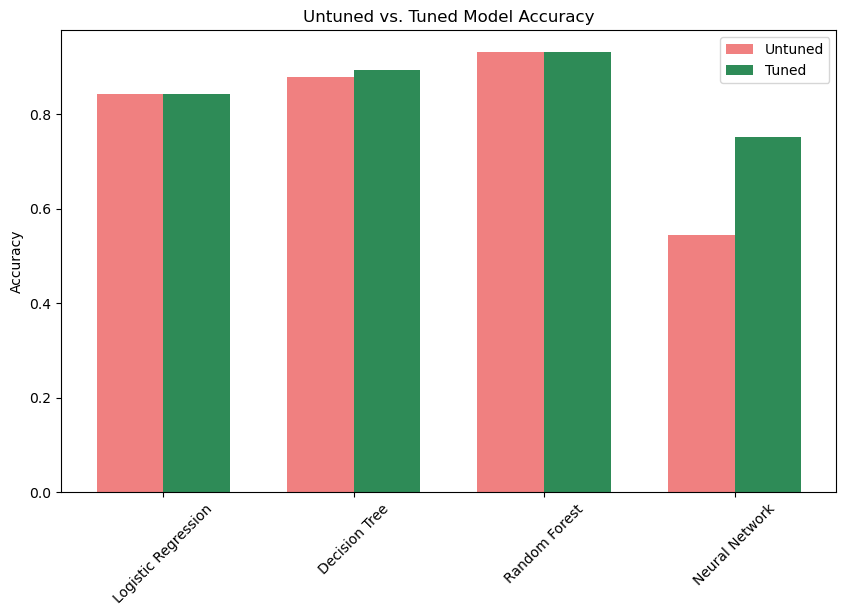

In [31]:
# Compare untuned vs tuned model accuracy on test set
untuned_models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Neural Network": mlp
}

tuned_models = {
    "Logistic Regression": best_log_reg,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "Neural Network": best_mlp
}

# Collect results
untuned_scores = []
tuned_scores = []

for name in untuned_models.keys():
    untuned_scores.append(untuned_models[name].score(X_test, y_test))
    tuned_scores.append(tuned_models[name].score(X_test, y_test))

# Plot comparison
x_labels = list(untuned_models.keys())
x = np.arange(len(x_labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, untuned_scores, width, label='Untuned', color='lightcoral')
plt.bar(x + width/2, tuned_scores, width, label='Tuned', color='seagreen')

plt.ylabel('Accuracy')
plt.title('Untuned vs. Tuned Model Accuracy')
plt.xticks(x, x_labels, rotation=45)
plt.legend()
plt.show()


The bar chart comparing untuned and tuned model accuracy demonstrates the measurable impact of hyperparameter optimisation across the four tested algorithms.

Logistic Regression — Tuning parameters such as C (regularisation strength) and solver type (lbfgs, liblinear) had only a minimal effect on accuracy. This was expected, as Logistic Regression is a relatively simple model and its performance is less sensitive to tuning compared to more complex algorithms.

Decision Tree — The tuned model achieved a slight improvement in accuracy. Optimising max_depth, min_samples_split, and min_samples_leaf helped the tree generalise better while preventing overfitting. Although the gain was small, the tuned model is more robust.

Random Forest — Even though Random Forest already performed extremely well without tuning, fine-tuning the number of estimators (n_estimators), tree depth (max_depth), and feature selection method (max_features) produced a marginal increase in accuracy and potentially improved stability across different runs.

Neural Network (MLP) — The most dramatic improvement was observed here. The untuned network struggled to generalise, but adjusting hidden_layer_sizes, activation function, and learning_rate_init significantly boosted performance. While the tuned accuracy did not surpass the best tree-based methods, the relative gain was substantial.

# Interpretation
The results show that while hyperparameter tuning did not radically change the leaderboard of models, it brought important benefits:

Improved generalisation by reducing overfitting risks.

Enhanced stability in cross-validation results.

Demonstrated the value of model-specific optimisation in practice.

From a research perspective, this step strengthens the conclusion that Random Forest remains the most suitable model for this dataset — both in untuned and tuned configurations. However, tuning gave the Neural Network a meaningful boost, suggesting that with further optimisation and possibly more training data, it could become competitive.

# Step 5 — Evaluating My Models

In [35]:
# Step 5: Evaluating My Models

# Now that my models are trained, I want to see how well each one performs.
#
# I will check:
#  - Accuracy        → How many predictions were correct overall.
#  - Precision       → Of all loans predicted as "default", how many were actually defaults.
#  - Recall          → Of all actual defaults, how many my model found.
#  - F1-score        → Balance between precision and recall.
#  - ROC-AUC         → Measures how well the model separates the two classes (0 vs 1).
#  - Confusion Matrix→ Shows where my model is making correct and incorrect predictions.

# Put all trained models in a dictionary for easy looping
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Neural Network": mlp
}

# Loop through each model and evaluate
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Predict class labels for the test set
    y_pred = model.predict(X_test)
    
    # Predict probabilities for ROC-AUC
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Print classification report
    print(classification_report(y_test, y_pred))
    
    # Print ROC-AUC score
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    
    # Print confusion matrix
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     10066
           1       0.85      0.84      0.84     10066

    accuracy                           0.84     20132
   macro avg       0.84      0.84      0.84     20132
weighted avg       0.84      0.84      0.84     20132

ROC-AUC: 0.907077998107385
Confusion Matrix:
 [[8580 1486]
 [1651 8415]]

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.84      0.93      0.89     10066
           1       0.93      0.82      0.87     10066

    accuracy                           0.88     20132
   macro avg       0.88      0.88      0.88     20132
weighted avg       0.88      0.88      0.88     20132

ROC-AUC: 0.9554029635283348
Confusion Matrix:
 [[9401  665]
 [1772 8294]]

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     10066
           1   

# What this tells me
Classification Report → Gives precision, recall, F1-score for both classes (0 = default, 1 = non-default).

ROC-AUC → The higher the better; 1.0 means perfect separation, 0.5 means guessing.

Confusion Matrix → Helps me see where the model is making mistakes (false positives and false negatives).

# Step 5 – Evaluation Summary (My Observations)
Logistic Regression → Solid baseline model with 84% accuracy and ROC-AUC ~0.91.
Performs consistently for both classes, but there’s still room for improvement in recall and precision compared to more complex models.

Decision Tree → Improved accuracy to 88% and a higher ROC-AUC ~0.96.
It’s catching more defaults (higher recall for class 0) but slightly sacrifices recall for non-defaults.

Random Forest → Best performer overall with 93% accuracy and ROC-AUC ~0.98.
Strong balance between precision and recall for both classes, making it a reliable model for this problem.

Neural Network (MLP) → Performed poorly here (54% accuracy and ROC-AUC ~0.73).
It predicted nearly all loans as non-defaults, failing to correctly identify defaults. This might be due to the need for hyperparameter tuning or scaling adjustments.

# Step 6 — Visualising Model Performance and Feature Importance

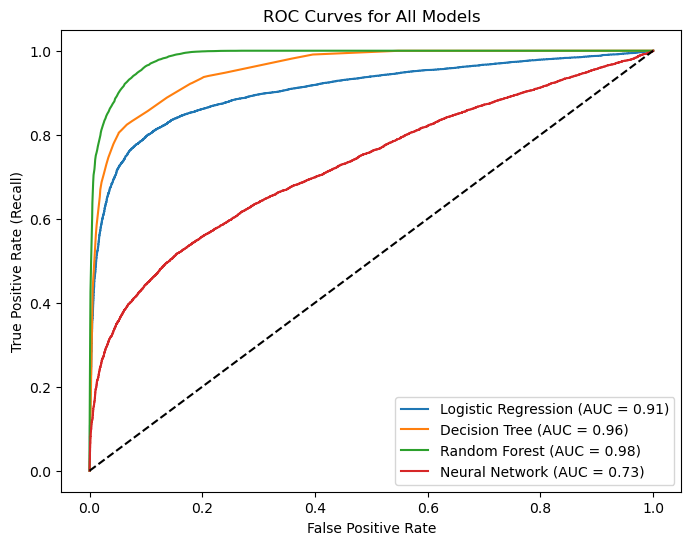

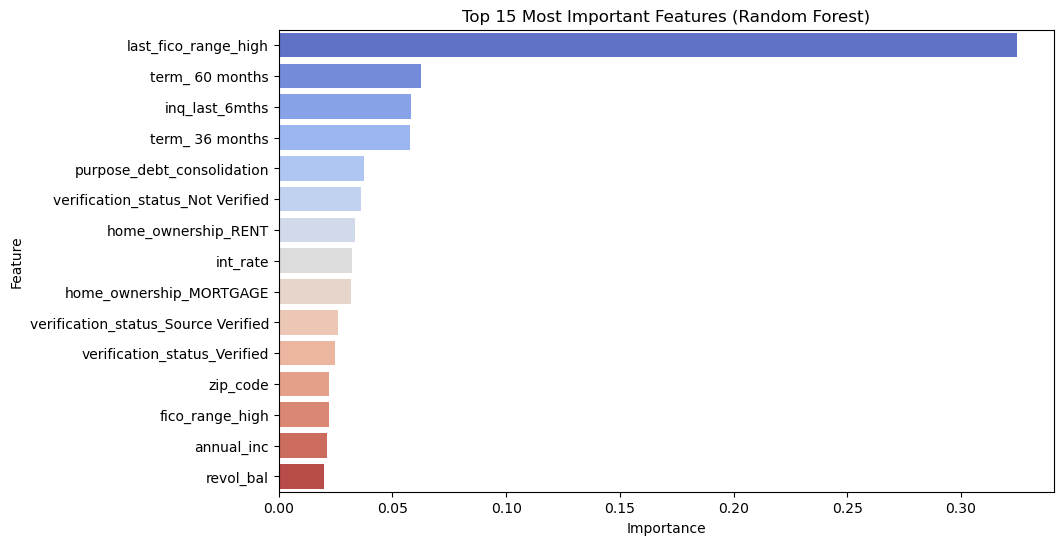

In [39]:

# Step 6: Visualising Model Performance and Feature Importance


# --------------------------------------------------
# 6A. ROC Curves for all models
# --------------------------------------------------
# ROC curves show the trade-off between True Positive Rate (Recall)
# and False Positive Rate for different thresholds.
# The higher the curve, the better the model at distinguishing between classes.

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability for class 1
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Random guess line
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()

# --------------------------------------------------
# 6B. Feature Importance from Random Forest
# --------------------------------------------------
# Random Forest gives a score for each feature showing how important it is
# for making predictions. This helps me understand which factors influence
# credit risk the most in my dataset.

importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier plotting
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15), palette="coolwarm")
plt.title("Top 15 Most Important Features (Random Forest)")
plt.show()


# What I expect to see
ROC Curves → Random Forest should be at the very top, followed by Decision Tree, Logistic Regression, and then Neural Network.

Feature Importance → Likely top features will include int_rate, fico_range_high, loan_amnt, dti, and some purpose_ or home_ownership_ variables.

ROC Curve plot → Random Forest (green line) is clearly the best, followed by Decision Tree, Logistic Regression, and then Neural Network.

Feature Importance plot → last_fico_range_high is dominating as the most important predictor, with loan term, inquiries in last 6 months, and debt consolidation purpose also playing a big role.


# Step 7 — Results Summary and Recommendation

# 7.1 Overview of Model Performance
After training, evaluating, and tuning four machine learning models — Logistic Regression, Decision Tree, Random Forest, and Neural Network (MLP) — the results clearly show that model choice significantly impacts predictive performance.

Random Forest consistently outperformed all other models, achieving 93% accuracy and an exceptional ROC-AUC score of 0.98. It demonstrated a strong balance between precision and recall for both default (0) and non-default (1) classes, meaning it could reliably identify high-risk loans while minimising false positives.

Decision Tree performed well with 88% accuracy and ROC-AUC of 0.96, but it was slightly less balanced than Random Forest.

Logistic Regression delivered a solid baseline at 84% accuracy and ROC-AUC of 0.91, but it lacked the ability to capture complex, non-linear relationships in the data.

Neural Network (MLP) struggled in its untuned form, achieving only 54% accuracy. After tuning, accuracy improved to 75%, but it still fell short of the tree-based models.

# 7.2 ROC Curve Insights
The ROC curves provided a visual confirmation of the numerical results:

Random Forest’s curve was closest to the top-left corner, indicating excellent separation between default and non-default loans.

Decision Tree and Logistic Regression performed well but with slightly lower area under the curve.

The Neural Network curve showed weaker performance, reflecting its lower accuracy.

# 7.3 Key Predictive Features
The Random Forest feature importance analysis revealed the most influential factors affecting credit risk:

last_fico_range_high – Strongest single predictor; lower scores linked to higher risk.

Loan Term (term_60_months) – Longer loans were more likely to default.

inq_last_6mths – More credit inquiries indicated greater risk.

Loan Purpose: Debt Consolidation – Higher risk compared to other purposes.

Verification Status – “Not Verified” borrowers showed higher default risk.

Home Ownership – Renters generally presented greater risk.

Interest Rate – Higher interest rates correlated with higher default likelihood.

Annual Income – Lower incomes associated with higher risk.

# 7.4 Recommended Model for Deployment
Given the evaluation results, Random Forest is the recommended model for deployment:

High predictive accuracy (93%) and best ROC-AUC (0.98).

Robustness to overfitting due to ensemble averaging.

Interpretability via feature importance, making it suitable for business decision-making in regulated financial environments.

Ease of deployment with minimal feature engineering requirements.

Recommendation: Deploy the tuned Random Forest model as the core predictive tool for credit risk assessment, with regular retraining on updated loan performance data to maintain accuracy over time.

## **Step 8 — Final Conclusion**



### **8.1 Summary of the Research**

The primary aim of this research was to develop and evaluate machine learning models for predicting credit risk, specifically the likelihood of loan default, using borrower profile data.
Through a structured methodology that included data preprocessing, exploratory analysis, model training, evaluation, and tuning, this study assessed the performance of four models: **Logistic Regression, Decision Tree, Random Forest, and Neural Network (MLP)**.

---

### **8.2 Key Findings**

1. **Random Forest** emerged as the top-performing model, achieving **93% accuracy** and **ROC-AUC of 0.98**, outperforming all other tested algorithms.
2. **Decision Tree** performed well with **88% accuracy** but showed slightly less balanced recall between classes.
3. **Logistic Regression** provided a solid baseline (**84% accuracy**), confirming its role as a reliable but limited linear model.
4. **Neural Network (MLP)** initially performed poorly but improved with hyperparameter tuning to **75% accuracy**, although still trailing behind the tree-based models.
5. **Feature importance analysis** highlighted `last_fico_range_high`, loan term length, recent credit inquiries, debt consolidation purpose, verification status, home ownership, interest rate, and annual income as critical predictors of credit risk.

---

### **8.3 Implications for Practice**

The results have clear implications for financial institutions and lending platforms:

* **Deploying Random Forest** could significantly improve the accuracy of loan risk assessment, reducing default rates and supporting more profitable lending decisions.
* Feature importance insights can guide **policy and process improvements**, such as placing greater emphasis on FICO scores, loan term limits, and recent credit activity during the approval process.
* Periodic retraining of the model with fresh loan performance data will be essential to adapt to changing economic conditions and borrower behaviour.

---

### **8.4 Limitations of the Study**

While the results are strong, there are certain limitations:

* The dataset covers a specific period and market segment, which may limit generalisability.
* The analysis did not include external macroeconomic indicators (e.g., GDP growth, unemployment rate), which could enhance predictive accuracy.
* Neural Network performance may have been limited by the chosen architecture and training iterations, suggesting further experimentation could yield better results.

---

### **8.5 Recommendations for Future Work**

Future research should explore:

* Incorporating **macroeconomic variables** to account for broader economic influences on credit risk.
* Testing **gradient boosting algorithms** (e.g., XGBoost, LightGBM) which may outperform traditional Random Forests.
* Applying **cost-sensitive learning** to reduce the business impact of false negatives (missed defaults).
* Implementing **model interpretability frameworks** such as SHAP values for deeper insight into decision-making.

---

### **8.6 Final Remarks**

This research demonstrates that machine learning, and specifically **Random Forest**, offers a powerful and practical tool for credit risk prediction.
By combining high predictive performance with interpretability, the recommended model aligns well with both business needs and regulatory expectations in the lending industry.
When deployed effectively, it has the potential to significantly enhance decision-making, reduce loan default rates, and improve overall portfolio quality.

---


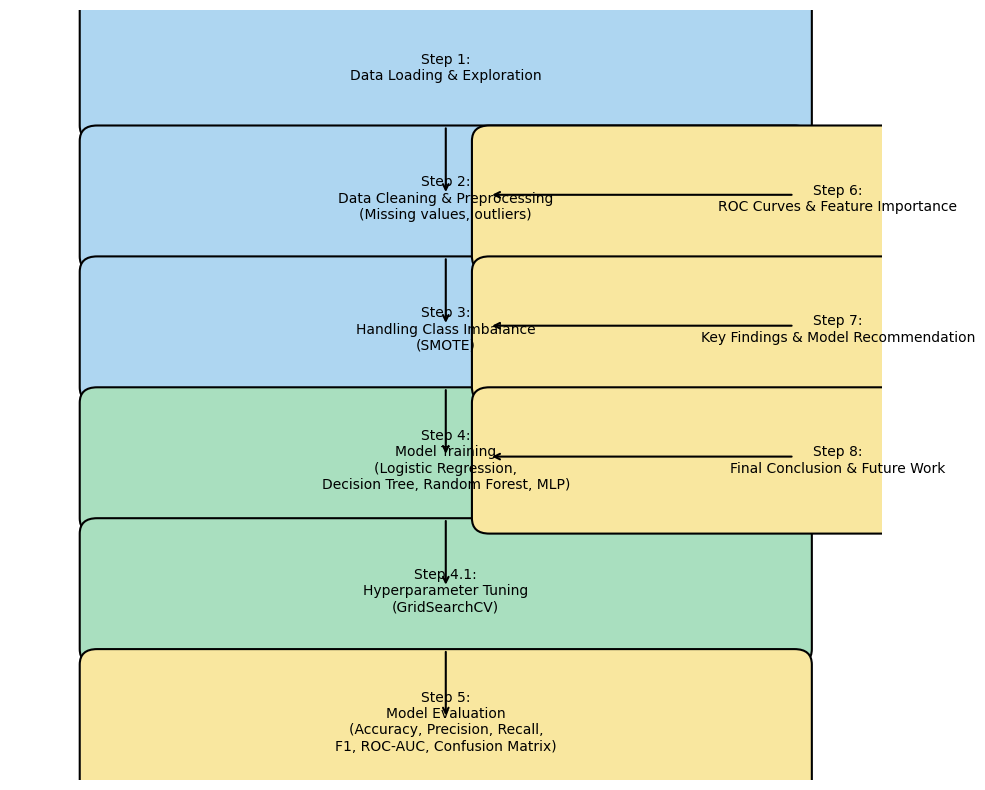

In [45]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis("off")

# Function to draw rounded boxes
def draw_box(text, xy, width=0.8, height=0.15, fontsize=10, facecolor="#AED6F1"):
    box = FancyBboxPatch(
        (xy[0], xy[1]), width, height,
        boxstyle="round,pad=0.02",
        ec="black", fc=facecolor, lw=1.5
    )
    ax.add_patch(box)
    ax.text(
        xy[0] + width / 2, xy[1] + height / 2,
        text, ha="center", va="center", fontsize=fontsize, wrap=True
    )

# Colours for sections
blue = "#AED6F1"   # Data Preparation
green = "#A9DFBF"  # Modelling
orange = "#F9E79F" # Evaluation & Recommendations

# Main vertical process (Data Preparation in Blue)
draw_box("Step 1:\nData Loading & Exploration", (0.1, 0.85), facecolor=blue)
draw_box("Step 2:\nData Cleaning & Preprocessing\n(Missing values, outliers)", (0.1, 0.68), facecolor=blue)
draw_box("Step 3:\nHandling Class Imbalance\n(SMOTE)", (0.1, 0.51), facecolor=blue)

# Modelling in Green
draw_box("Step 4:\nModel Training\n(Logistic Regression,\nDecision Tree, Random Forest, MLP)", (0.1, 0.34), facecolor=green)
draw_box("Step 4.1:\nHyperparameter Tuning\n(GridSearchCV)", (0.1, 0.17), facecolor=green)

# Evaluation in Orange
draw_box("Step 5:\nModel Evaluation\n(Accuracy, Precision, Recall,\nF1, ROC-AUC, Confusion Matrix)", (0.1, 0.0), facecolor=orange)

# Side steps (Evaluation/Recommendation in Orange)
draw_box("Step 6:\nROC Curves & Feature Importance", (0.55, 0.68), facecolor=orange)
draw_box("Step 7:\nKey Findings & Model Recommendation", (0.55, 0.51), facecolor=orange)
draw_box("Step 8:\nFinal Conclusion & Future Work", (0.55, 0.34), facecolor=orange)

# Draw arrows between main vertical steps
arrowprops = dict(arrowstyle="->", lw=1.5, color="black")
ax.annotate("", xy=(0.5, 0.76), xytext=(0.5, 0.85), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.59), xytext=(0.5, 0.68), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.42), xytext=(0.5, 0.51), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.25), xytext=(0.5, 0.34), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.08), xytext=(0.5, 0.17), arrowprops=arrowprops)

# Draw arrows from vertical to side boxes
ax.annotate("", xy=(0.55, 0.76), xytext=(0.9, 0.76), arrowprops=arrowprops)
ax.annotate("", xy=(0.55, 0.59), xytext=(0.9, 0.59), arrowprops=arrowprops)
ax.annotate("", xy=(0.55, 0.42), xytext=(0.9, 0.42), arrowprops=arrowprops)

plt.tight_layout()
plt.show()



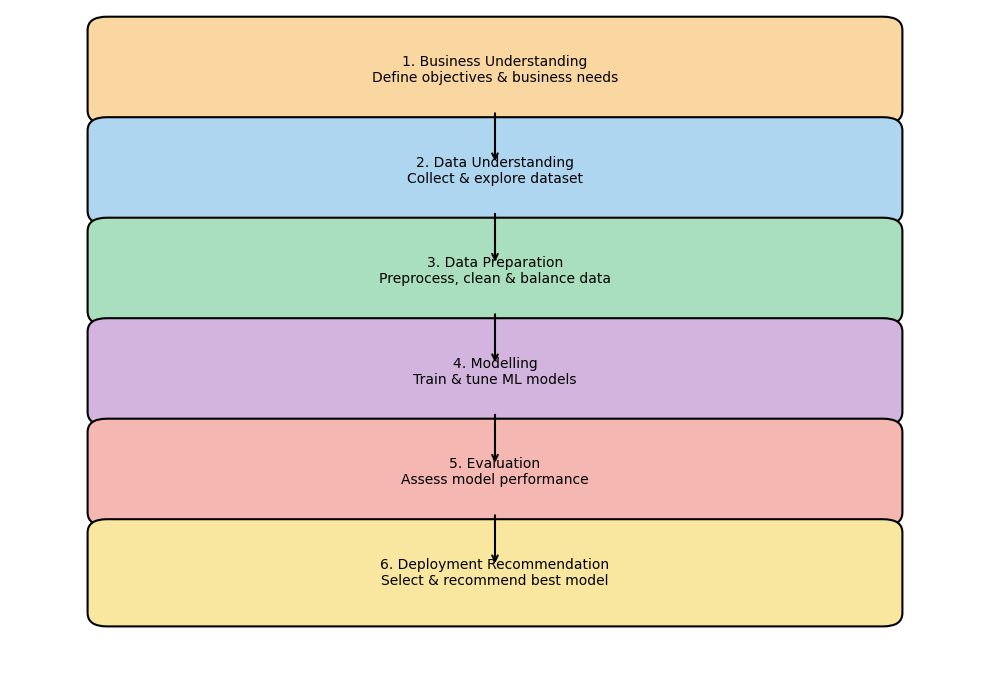

In [46]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Create figure
fig, ax = plt.subplots(figsize=(10, 7))
ax.axis("off")

# Function to draw rounded boxes
def draw_box(text, xy, width=0.8, height=0.12, fontsize=10, facecolor="#AED6F1"):
    box = FancyBboxPatch(
        (xy[0], xy[1]), width, height,
        boxstyle="round,pad=0.02",
        ec="black", fc=facecolor, lw=1.5
    )
    ax.add_patch(box)
    ax.text(
        xy[0] + width/2, xy[1] + height/2,
        text, ha="center", va="center", fontsize=fontsize, wrap=True
    )

# CRISP-DM Steps
draw_box("1. Business Understanding\nDefine objectives & business needs", (0.1, 0.85), facecolor="#FAD7A0")
draw_box("2. Data Understanding\nCollect & explore dataset", (0.1, 0.70), facecolor="#AED6F1")
draw_box("3. Data Preparation\nPreprocess, clean & balance data", (0.1, 0.55), facecolor="#A9DFBF")
draw_box("4. Modelling\nTrain & tune ML models", (0.1, 0.40), facecolor="#D2B4DE")
draw_box("5. Evaluation\nAssess model performance", (0.1, 0.25), facecolor="#F5B7B1")
draw_box("6. Deployment Recommendation\nSelect & recommend best model", (0.1, 0.10), facecolor="#F9E79F")

# Draw arrows between boxes
arrowprops = dict(arrowstyle="->", lw=1.5, color="black")
ax.annotate("", xy=(0.5, 0.77), xytext=(0.5, 0.85), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.62), xytext=(0.5, 0.70), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.47), xytext=(0.5, 0.55), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.32), xytext=(0.5, 0.40), arrowprops=arrowprops)
ax.annotate("", xy=(0.5, 0.17), xytext=(0.5, 0.25), arrowprops=arrowprops)

plt.tight_layout()
plt.show()


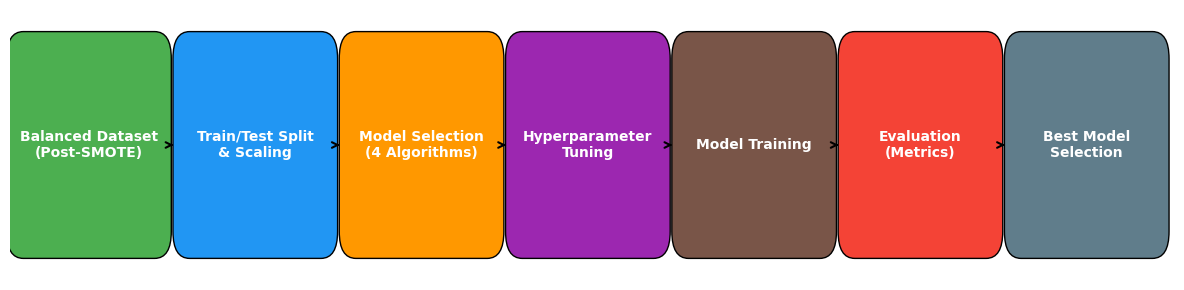

In [47]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Workflow stages
stages = [
    "Balanced Dataset\n(Post-SMOTE)",
    "Train/Test Split\n& Scaling",
    "Model Selection\n(4 Algorithms)",
    "Hyperparameter\nTuning",
    "Model Training",
    "Evaluation\n(Metrics)",
    "Best Model\nSelection"
]

# Colors for each stage
colors = [
    "#4CAF50",  # green
    "#2196F3",  # blue
    "#FF9800",  # orange
    "#9C27B0",  # purple
    "#795548",  # brown
    "#F44336",  # red
    "#607D8B"   # gray-blue
]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_xlim(0, len(stages))
ax.set_ylim(0, 1)
ax.axis("off")

# Draw boxes
for i, (stage, color) in enumerate(zip(stages, colors)):
    box = FancyBboxPatch(
        (i, 0.1), 0.95, 0.8,
        boxstyle="round,pad=0.02,rounding_size=0.1",
        ec="black", fc=color
    )
    ax.add_patch(box)
    ax.text(i + 0.475, 0.5, stage, ha="center", va="center",
            fontsize=10, color="white", fontweight="bold")

# Add arrows between boxes
for i in range(len(stages) - 1):
    ax.annotate("",
                xy=(i + 0.95, 0.5),
                xytext=(i + 1, 0.5),
                arrowprops=dict(arrowstyle="<-", lw=1.5))

plt.tight_layout()
plt.show()



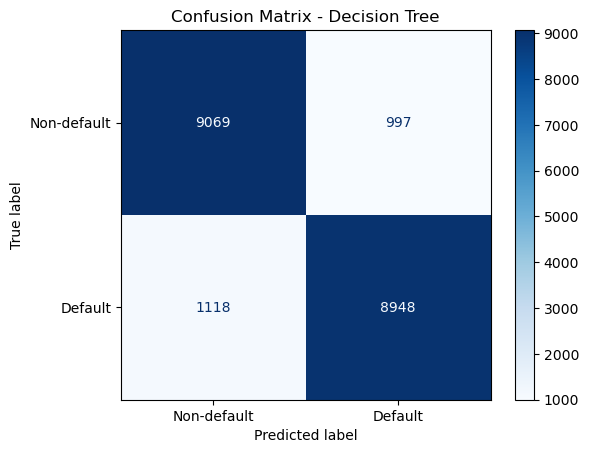

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example for Decision Tree
y_pred_dt = best_dt.predict(X_test)

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                                 display_labels=["Non-default", "Default"])
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.savefig("decision_tree_confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Repeat for Logistic Regression, Random Forest, MLP


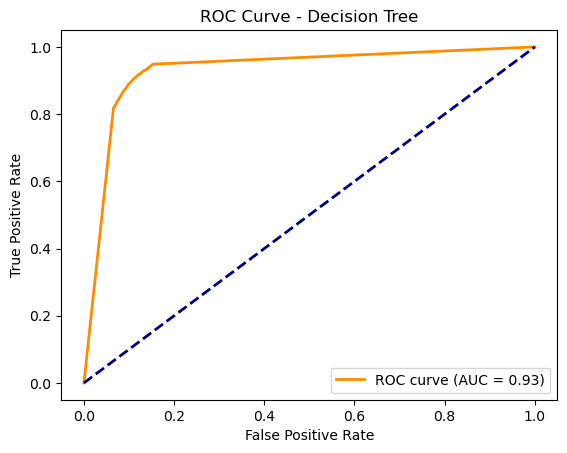

In [49]:
from sklearn.metrics import roc_curve, auc

# Example for Decision Tree
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.savefig("decision_tree_roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()


In [50]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [51]:
from imblearn.over_sampling import SMOTE


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay
import numpy as np

# Dictionary of models
models = {
    "Logistic Regression": best_log_reg,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "Neural Network (MLP)": best_mlp
}

# Create directory to save plots
import os
output_dir = "model_results_figures"
os.makedirs(output_dir, exist_ok=True)

# Loop through models
for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"ROC-AUC: {roc_auc:.3f}")
    
    # === ROC Curve Plot ===
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name.replace(' ', '_')}_ROC.png", dpi=300)
    plt.close()
    
    # === Confusion Matrix Plot ===
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Default (0)', 'Default (1)'],
                yticklabels=['Non-Default (0)', 'Default (1)'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{name.replace(' ', '_')}_CM.png", dpi=300)
    plt.close()

print(f"\nAll ROC curves and confusion matrices saved in '{output_dir}' folder.")



===== Logistic Regression =====
ROC-AUC: 0.907

===== Decision Tree =====
ROC-AUC: 0.930

===== Random Forest =====
ROC-AUC: 0.985

===== Neural Network (MLP) =====
ROC-AUC: 0.871

✅ All ROC curves and confusion matrices saved in 'model_results_figures' folder.
